# LCI Analysis

In [1]:
%load_ext autoreload
%autoreload 2


import sys, os
import pickle
from collections import defaultdict, Counter

import numpy as np
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import pandas as pd
import networkx as nx
from tqdm import tqdm_notebook as tqdm
import goatools
from goatools.base import download_go_basic_obo, download_ncbi_associations
from goatools.obo_parser import GODag
from goatools.associations import read_ncbi_gene2go
from goatools.go_enrichment import GOEnrichmentStudy
#from tqdm import tqdm_notebook as tqdm

from dpp.data.network import PPINetwork
from dpp.data.go import load_go_annotations
from dpp.data.drug import load_drug_targets
from dpp.util import Params, prepare_sns, load_mapping, build_degree_buckets, compute_pvalue
from dpp.data.associations import load_diseases

os.chdir("/Users/sabrieyuboglu/Documents/School/SNAP/projects/disease-protein-prediction")
#os.chdir("/dfs/scratch0/sabri/disease-protein-prediction")
prepare_sns(sns)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [2]:
diseases = load_diseases("data/associations/disgenet-associations.csv", exclude_splits=["none"])
entrez_to_name = load_mapping("data/protein/symbol_to_entrez.txt", "\t", reverse=True,
                              b_transform=int)

In [3]:
network = PPINetwork("data/networks/bio-pathways-network.txt")

In [4]:
experiment_dir = "experiments/dpp_predict/lci_new"

In [14]:
base_params={
    "ppi_network": "data/networks/bio-pathways-network.txt",
    
    "diseases_path": "data/associations/disgenet-associations.csv",
    "disease_subset": [],
    
    "model_path": "experiments/dpp_predict/lci_new/"
}

### Load Weights
Specify a split from which to load weights

In [5]:
with open(os.path.join(experiment_dir, "models", "models.tar"), "rb") as f:
    split_to_model = pickle.load(f)

In [6]:
dicts = []
for split in tqdm(range(10)):
    model = split_to_model[split]
    model_stats = {
        "weight": model['linear_layer.weight'].item(), 
        "bias": model['linear_layer.bias'].item(), 
        "mean_z": np.mean(model['ci_weight'][0, 0].numpy())
    }
    dicts.append(model_stats)
model_df = pd.DataFrame(dicts, columns=["weight", "bias", "mean_z"])
model_df

,weight,bias,mean_z
0,17.550322,-0.811245,0.241408
1,17.876070,-0.723686,0.220373
2,16.029150,-1.334732,0.229375
3,16.782249,-0.696910,0.212054
4,18.501001,-1.084714,0.215662
5,15.429231,-1.496836,0.192651
6,16.680628,-0.571429,0.226772
7,12.891609,-1.300265,0.302289
8,17.751625,-0.990272,0.245099
9,16.344975,-0.574154,0.196769


In [8]:
ci_weights = np.mean([model['ci_weight'][0, 0].numpy() for model in split_to_model.values()], axis=0)

## Weight Distribution

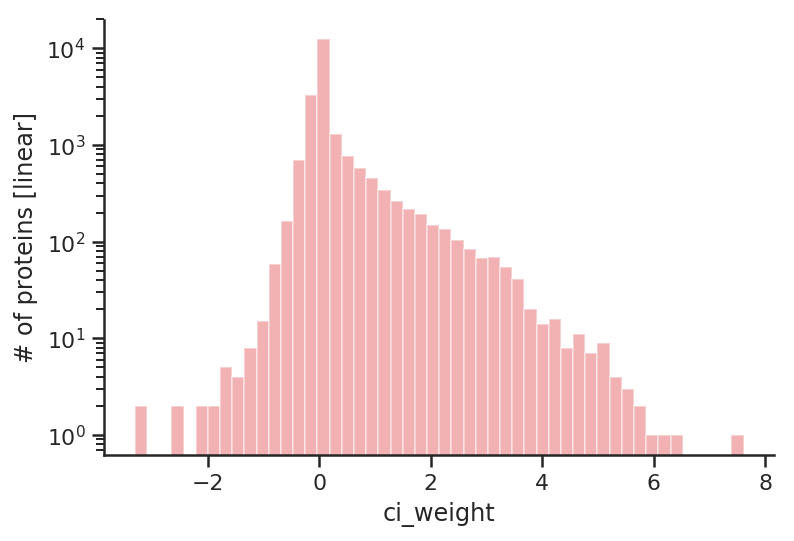

In [9]:
sns.distplot(ci_weights, kde=False)
plt.yscale('log')
plt.xlabel("ci_weight")
plt.ylabel("# of proteins [linear]")
sns.despine()

## Network Properties

### Degree


In [53]:
degrees = np.array(list(dict(network.nx.degree()).values()))

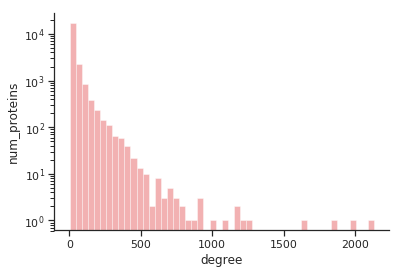

In [10]:
sns.distplot(degrees, kde=False)
plt.yscale('log')
plt.xlabel("degree")
plt.ylabel("num_proteins")
sns.despine()

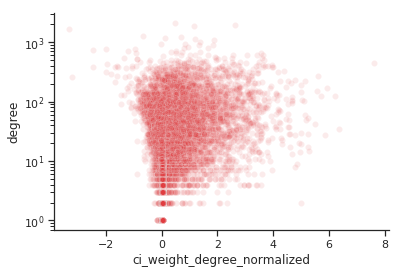

In [11]:
sns.scatterplot(ci_weights, degrees, alpha=0.1)
plt.yscale('log')
plt.ylabel("degree")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

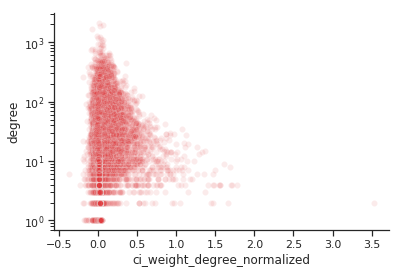

In [12]:
sns.scatterplot(ci_weights / (np.sqrt(degrees)), degrees, alpha=0.1)
plt.yscale('log')
plt.ylabel("degree")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

In [13]:
degree_df = pd.DataFrame({"degree": degrees,
                          "ci_weight": ci_weights})
mean_degree_df = degree_df.groupby("degree").mean()

Text(0, 0.5, 'mean normalized weight')

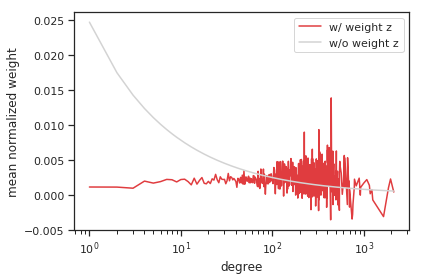

In [14]:
mean_degree_df = degree_df.groupby("degree").mean()
mean_norm_weights = mean_degree_df["ci_weight"] / np.power(mean_degree_df.index, 1/2) #/np.sqrt(mean_degree_df.index) # normalize by degree
mean_norm_weights = mean_norm_weights / mean_norm_weights.sum()
sns.lineplot(x=mean_degree_df.index, y=mean_norm_weights, label='w/ weight z')
y = 1/np.power(mean_degree_df.index, 1/2)
y = y/y.values.sum()
sns.lineplot(x=mean_degree_df.index, y=y, label='w/o weight z')
plt.xscale('log')
plt.yscale('linear')
plt.xlabel('degree')
plt.ylabel('mean normalized weight')

### Triangle Clustering Coefficient

In [15]:
triangles = nx.clustering(network.nx)

In [16]:
triangles = np.array(list(triangles.values()))

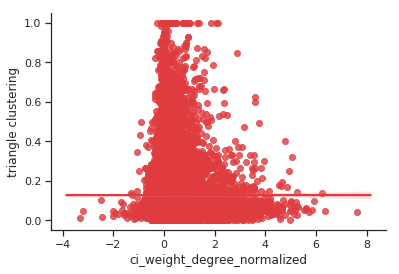

In [71]:
sns.regplot(ci_weights, triangles)
plt.yscale('linear')
plt.xscale('linear')
plt.ylabel("triangle clustering")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

#### Square Clustering Coefficient

In [72]:
squares = nx.square_clustering(network.nx)
squares = np.array(list(squares.values()))

In [83]:
squares[5185] = 0.0

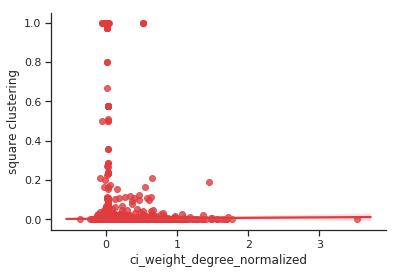

In [84]:
sns.regplot(ci_weights / np.sqrt(degrees), squares)
plt.yscale('linear')
plt.xscale('linear')
plt.ylabel("square clustering")
plt.xlabel("ci_weight_degree_normalized")
sns.despine()

## Protein Properties

### Terms Significance

In [9]:
term_to_proteins = load_go_annotations(network.get_proteins(), level=1)

data/go/go-basic.obo: fmt(1.2) rel(2019-01-19) 47,379 GO Terms
  20,385 items READ: data/go/gene2go.txt


In [21]:
degree_to_bucket = build_degree_buckets(network, min_len=100)

In [22]:
def get_null_pathways(pathway, quantity=1):
        """
        Given a reference pathway, generate quantity 
        """
        null_pathways = np.zeros((quantity, len(pathway)), dtype=int)
        for i, node in enumerate(pathway):
            degree = network.nx.degree[node]
            null_nodes = np.random.choice(degree_to_bucket[degree], 
                                          size=quantity, 
                                          replace=True)
            null_pathways[:, i] = null_nodes
    
        return null_pathways

In [23]:
# compute pvalues
def functional_pvalue(values):
    """
    """
    term_to_stats = {}
    for term, proteins in tqdm(term_to_proteins.items()):
        nodes = network.get_nodes(term_to_proteins[term])
        term_median = np.median(values[nodes])
        null_proteins = get_null_pathways(nodes, quantity=1000)
        null_medians = np.median(values[null_proteins], axis=1)

        pvalue = compute_pvalue(term_median, null_medians)

        term_to_stats[term] = {
            "pvalue": pvalue,
            "median_weight": term_median, 
            "num_proteins": len(nodes)
        }
    return term_to_stats

In [24]:
term_to_stats = functional_pvalue(ci_weights/np.sqrt(degrees))

In [83]:
norm_term_df = pd.DataFrame(term_to_stats.values(), index=term_to_stats.keys())
norm_term_df.to_csv("experiments/lci_analysis/terms.csv")
norm_term_df

,median_weight,num_proteins,pvalue
localization,0.017672,4361,0.000
membrane-enclosed lumen,0.026441,1184,0.000
cell part,0.014150,14714,0.165
extracellular region part,0.022696,3159,0.000
cellular process,0.015438,12622,0.000
immune system process,0.025622,1962,0.000
organelle,0.014459,10244,0.056
organelle part,0.014355,9029,0.110
response to stimulus,0.022697,4664,0.000
biological regulation,0.015923,10640,0.000


In [84]:
term_df = pd.DataFrame(term_to_stats.values(), index=term_to_stats.keys())
term_df.to_csv("experiments/lci_analysis/level_1.csv")
term_df

,median_weight,num_proteins,pvalue
localization,0.017672,4361,0.000
membrane-enclosed lumen,0.026441,1184,0.000
cell part,0.014150,14714,0.165
extracellular region part,0.022696,3159,0.000
cellular process,0.015438,12622,0.000
immune system process,0.025622,1962,0.000
organelle,0.014459,10244,0.056
organelle part,0.014355,9029,0.110
response to stimulus,0.022697,4664,0.000
biological regulation,0.015923,10640,0.000


### Functional Enrichment of Heavily Weighted Proteins
How does the enrichment of the top-k proteins compare 

In [9]:
goeaobj = GOEnrichmentStudy(network.get_proteins(), # List of mouse protein-coding genes
                            geneid2go, # geneid/GO associations
                            obodag, # Ontologies
                            propagate_counts = True,
                            alpha = 0.05, # default significance cut-off
                            methods = ['fdr_bh']) # defult multipletest correction method

fisher module not installed.  Falling back on scipy.stats.fisher_exact


Propagating term counts to parents ..


 76% 16,420 of 21,557 population items found in association


In [45]:
# get top proteins
ci_weights_norm = ci_weights / degrees
top_nodes = np.argsort(ci_weights_norm)[-75:]
top_proteins = network.get_proteins(top_nodes)

In [46]:
results = goeaobj.run_study(set(top_proteins))

 89%     67 of     75 study items found in association
100%     75 of     75 study items found in population(21557)
Calculating 21,968 uncorrected p-values using fisher_scipy_stats
  21,968 GO terms are associated with 16,420 of 21,557 population items
   2,252 GO terms are associated with     67 of     75 study items
      49 GO terms found significant (< 0.05=alpha) after multitest correction: statsmodels fdr_bh


In [48]:
significant = {r.name: r.p_fdr_bh for r in results if r.p_fdr_bh < 0.05}

In [49]:
significant

{'signal transduction': 0.0005938844649390932,
 'cell surface receptor signaling pathway': 0.0025603925031880766,
 'cell-cell signaling': 0.0033180978748671435,
 'G protein-coupled receptor signaling pathway': 0.0040166786054991925,
 'homeostatic process': 0.006388227529843405,
 'signaling': 0.006388227529843405,
 'positive regulation of catecholamine secretion': 0.010775868048983098,
 'cellular chemical homeostasis': 0.01266088447326542,
 'cellular homeostasis': 0.013101441361932685,
 'regulation of multicellular organismal process': 0.013101441361932685,
 'cell communication': 0.013101441361932685,
 'neuropeptide signaling pathway': 0.013101441361932685,
 'developmental process': 0.015097235875968208,
 'phosphatidylinositol-3-phosphate biosynthetic process': 0.015097235875968208,
 'phosphatidylinositol phosphorylation': 0.02053010404010572,
 'peptidyl-tyrosine phosphorylation': 0.02182335713005853,
 'peptidyl-tyrosine modification': 0.023352145909529096,
 'lipid phosphorylation': 0.0

### Drug Analysis

In [28]:
from dpp.experiments.lci_analysis import DrugTarget

#### All Drugs

In [176]:
all_drugs_exp = DrugTarget(
    dir="experiments/lci_analysis/drug_target",
    params={**base_params, **{
        "drug_targets_path": "data/drug/drug_targets.txt",
        "top_k": 500
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading drugs...


In [52]:
all_drugs_exp.compute_drug_counts()

Text(0, 0.5, 'num proteins')

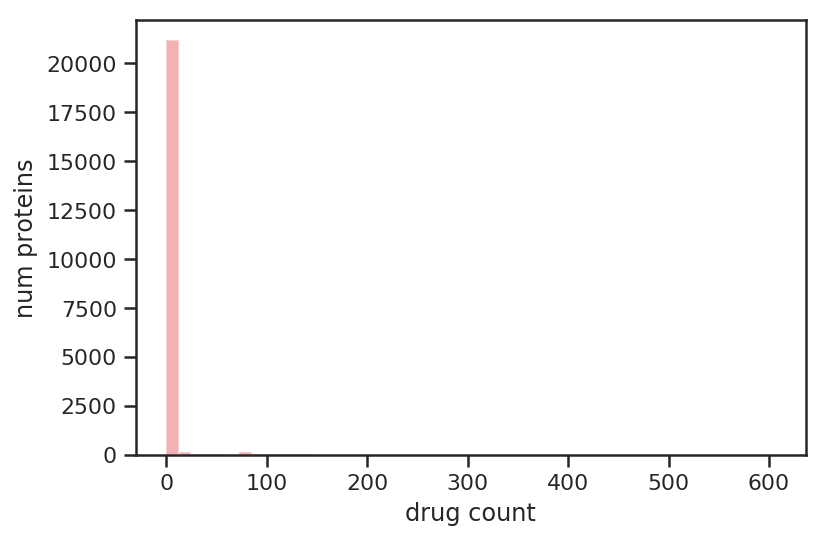

In [37]:
sns.distplot(all_drugs_exp.drug_counts, kde=False)
plt.yscale('linear')
plt.xlabel("drug count")
plt.ylabel("num proteins")

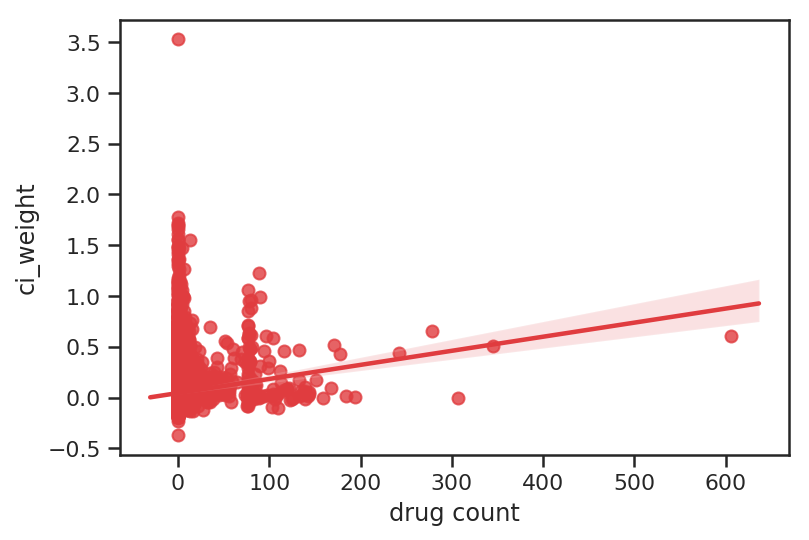

In [38]:
sns.regplot(all_drugs_exp.drug_counts, all_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("linear")
plt.yscale('linear')

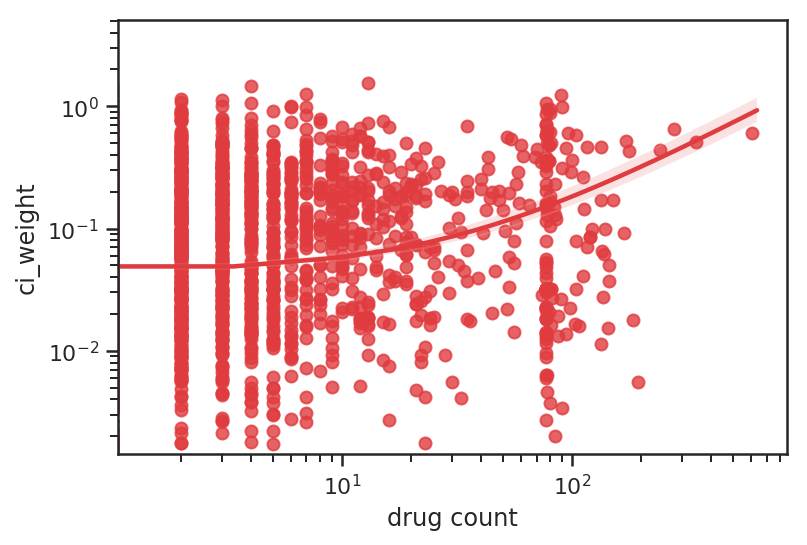

In [39]:
sns.regplot(all_drugs_exp.drug_counts, all_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("log")
plt.yscale('log')

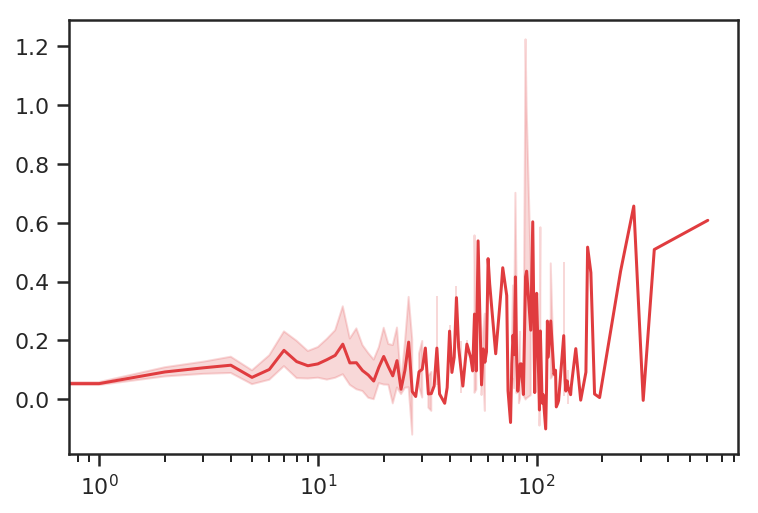

In [40]:
sns.lineplot(all_drugs_exp.drug_counts, all_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xscale('log')

In [55]:
# all proteins
all_drugs_exp.compute_weight_stats()

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [56]:
# targetted proteins
all_drugs_exp.compute_weight_stats(np.where(all_drugs_exp.drug_counts != 0))

{'mean': 0.07767503140960627,
 'median': 0.02037503384053707,
 'std': 0.1634200166301472}

In [57]:
# not targetted proteins
all_drugs_exp.compute_weight_stats(np.where(all_drugs_exp.drug_counts == 0))

{'mean': 0.03794204653499162,
 'median': 0.01881305182268994,
 'std': 0.11314030248033469}

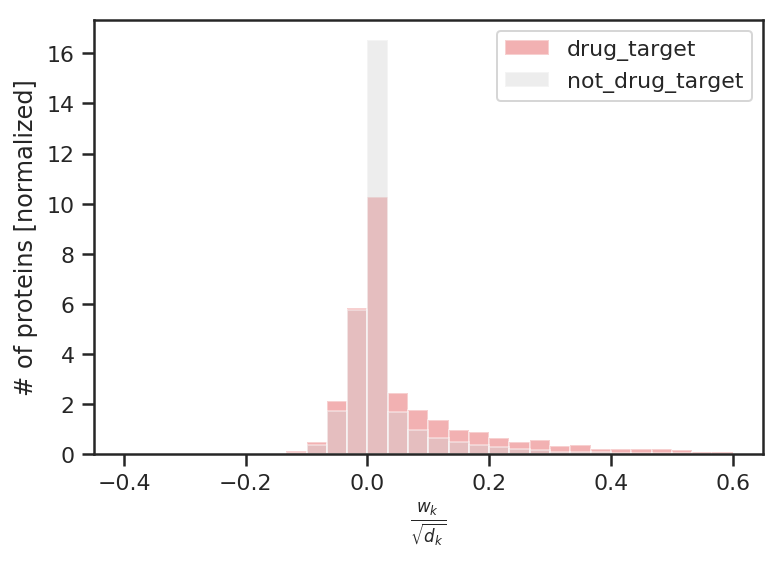

In [65]:
all_drugs_exp.plot_drug_weight_dist({"drug_target": np.where(all_drugs_exp.drug_counts > 0),
                                     "not_drug_target": np.where(all_drugs_exp.drug_counts == 0)})

In [87]:
top_proteins = np.argsort(all_drugs_exp.ci_weights_norm)[-500:]

In [89]:
all_drugs_exp.compute_frac_targets(top_proteins)

0.448

In [92]:
bottom_proteins = np.argsort(all_drugs_exp.ci_weights_norm)[:-500]

In [93]:
all_drugs_exp.compute_frac_targets(bottom_proteins)

0.20463503822956736

In [95]:
all_drugs_exp.frac_targets_ks_test(top_proteins, bottom_proteins)

Ks_2sampResult(statistic=0.24336496177043254, pvalue=7.778734195243265e-26)

In [177]:
all_drugs_exp.run()

True

#### CID Drugs

In [171]:
cid_drugs_exp = DrugTarget(
    dir="experiments/lci_analysis/cid_drug_target",
    params={**base_params, **{
        "drug_targets_path": "data/drug/cid_drug_targets.txt",
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading drugs...


In [101]:
cid_drugs_exp.compute_drug_counts()

Text(0, 0.5, 'num proteins')

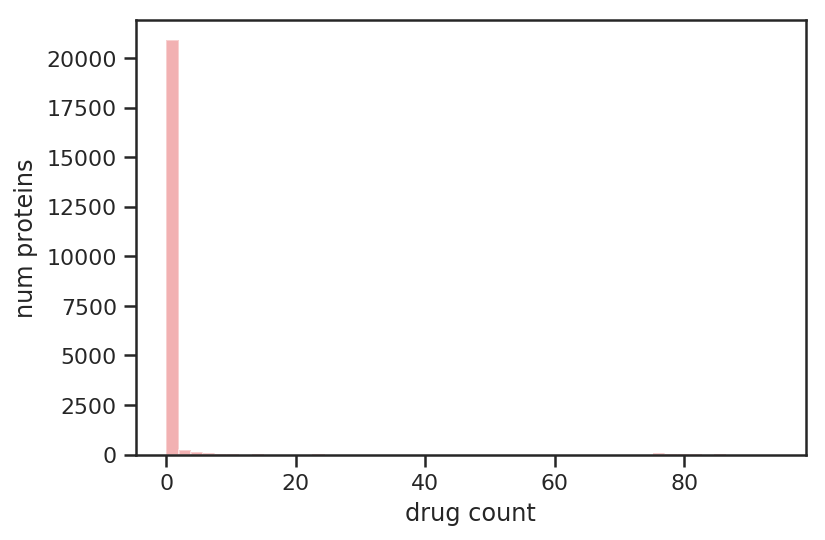

In [102]:
sns.distplot(cid_drugs_exp.drug_counts, kde=False)
plt.yscale('linear')
plt.xlabel("drug count")
plt.ylabel("num proteins")

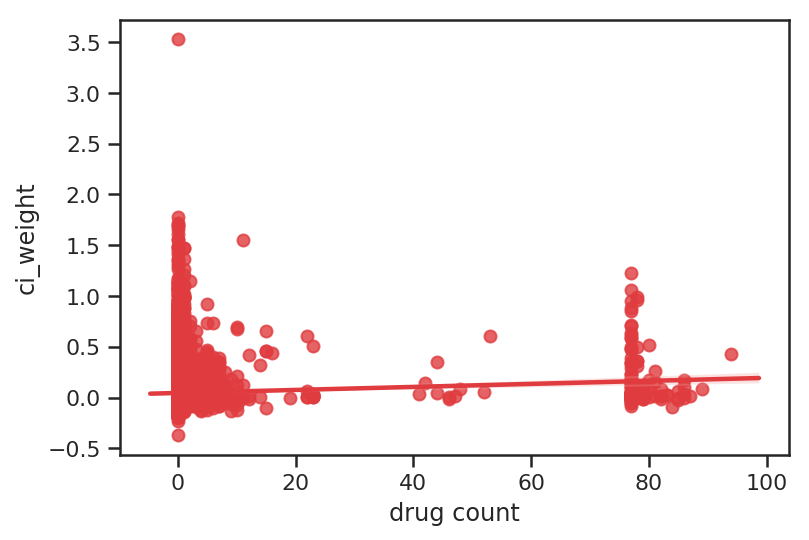

In [103]:
sns.regplot(cid_drugs_exp.drug_counts, cid_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("linear")
plt.yscale('linear')

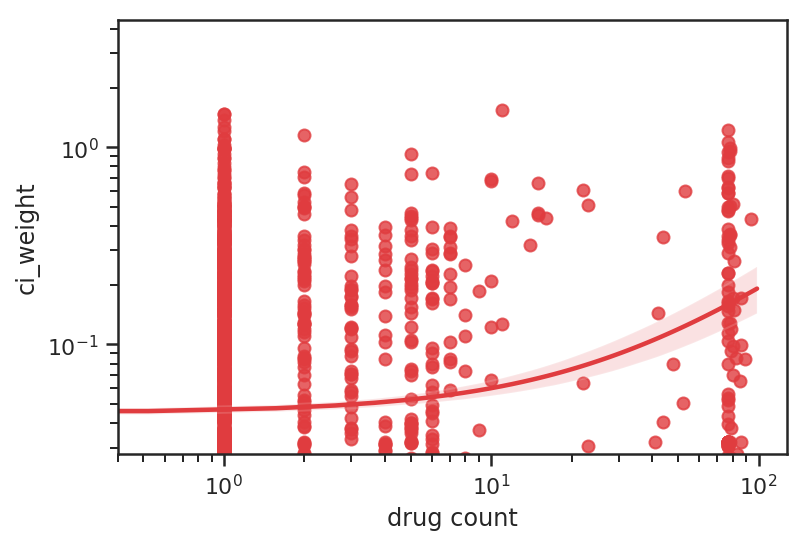

In [104]:
sns.regplot(cid_drugs_exp.drug_counts, cid_drugs_exp.ci_weights/np.sqrt(cid_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("log")
plt.yscale('log')

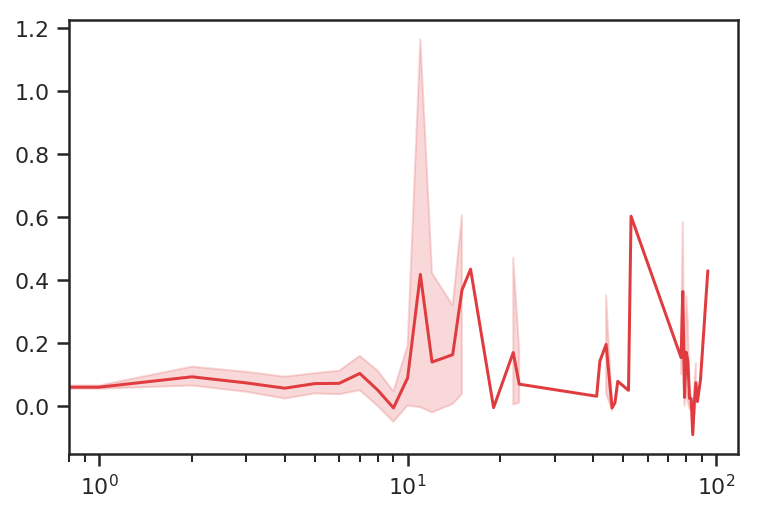

In [105]:
sns.lineplot(cid_drugs_exp.drug_counts, cid_drugs_exp.ci_weights/np.sqrt(cid_drugs_exp.degrees))
plt.xscale('log')

In [111]:
# all proteins
cid_drugs_exp.compute_weight_stats()

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [112]:
# targetted proteins
cid_drugs_exp.compute_weight_stats(np.where(cid_drugs_exp.drug_counts != 0))

{'mean': 0.0685163657260583,
 'median': 0.018142021398254386,
 'std': 0.15579819623183355}

In [113]:
# not targetted proteins
cid_drugs_exp.compute_weight_stats(np.where(cid_drugs_exp.drug_counts == 0))

{'mean': 0.04225212388994512,
 'median': 0.019421240595679342,
 'std': 0.11988409527949778}

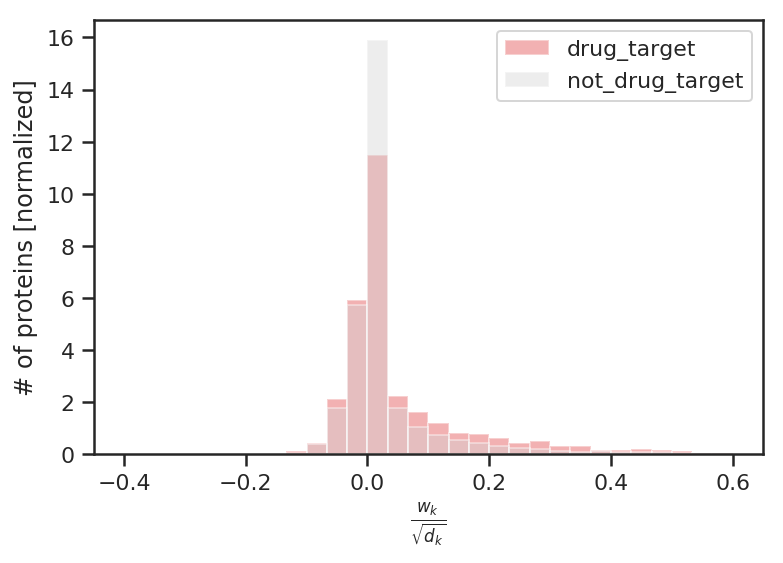

In [114]:
cid_drugs_exp.plot_drug_weight_dist({"drug_target": np.where(cid_drugs_exp.drug_counts > 0),
                                     "not_drug_target": np.where(cid_drugs_exp.drug_counts == 0)})

In [115]:
top_proteins = np.argsort(cid_drugs_exp.ci_weights_norm)[-500:]

In [116]:
cid_drugs_exp.compute_frac_targets(top_proteins)

0.272

In [117]:
bottom_proteins = np.argsort(cid_drugs_exp.ci_weights_norm)[:-500]

In [118]:
cid_drugs_exp.compute_frac_targets(bottom_proteins)

0.15120862421047632

In [119]:
cid_drugs_exp.frac_targets_ks_test(top_proteins, bottom_proteins)

Ks_2sampResult(statistic=0.1207913757895237, pvalue=1.0995139465330812e-06)

In [174]:
cid_drugs_exp.add_params({"top_k": 500})

In [175]:
cid_drugs_exp.run()

True

#### DB Drugs

In [164]:
db_drugs_exp = DrugTarget(
    dir="experiments/lci_analysis/db_drug_target",
    params={**base_params, **{
        "drug_targets_path": "data/drug/db_drug_targets.txt",
    }}
)

Loading disease associations...
Loading network...
Loading weights...
Loading drugs...


In [122]:
db_drugs_exp.compute_drug_counts()

Text(0, 0.5, 'num proteins')

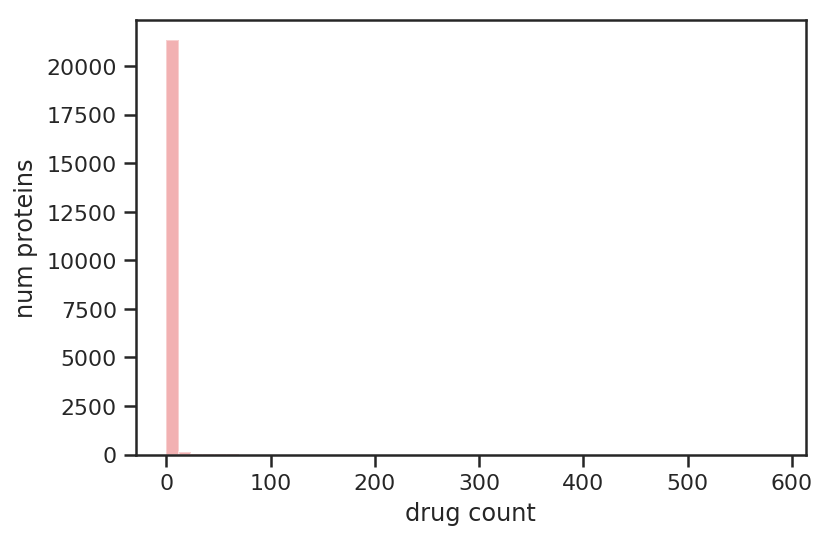

In [123]:
sns.distplot(db_drugs_exp.drug_counts, kde=False)
plt.yscale('linear')
plt.xlabel("drug count")
plt.ylabel("num proteins")

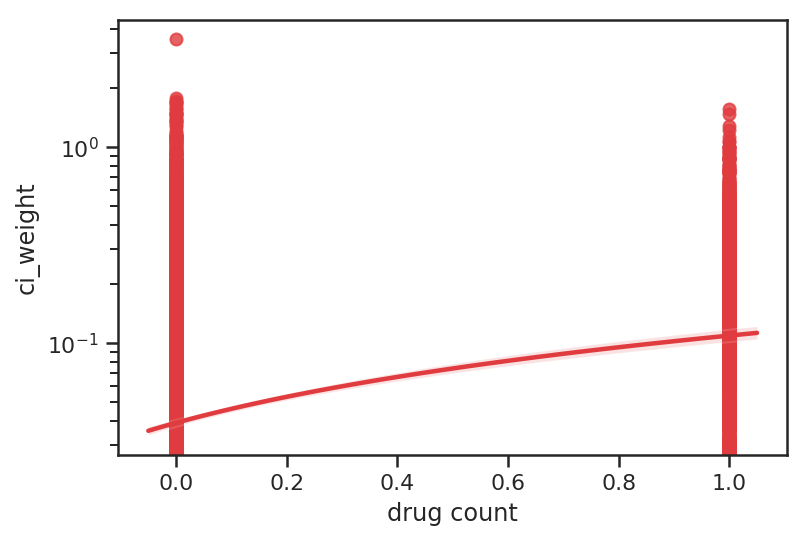

In [161]:
sns.regplot(db_drugs_exp.drug_counts != 0, db_drugs_exp.ci_weights/np.sqrt(db_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("linear")
plt.yscale('log')

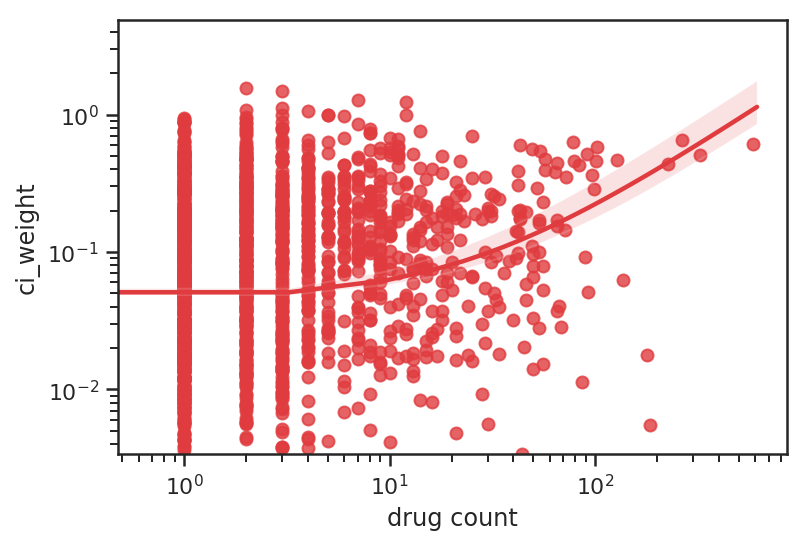

In [125]:
sns.regplot(db_drugs_exp.drug_counts, db_drugs_exp.ci_weights/np.sqrt(db_drugs_exp.degrees))
plt.xlabel("drug count")
plt.ylabel("ci_weight")
plt.xscale("log")
plt.yscale('log')

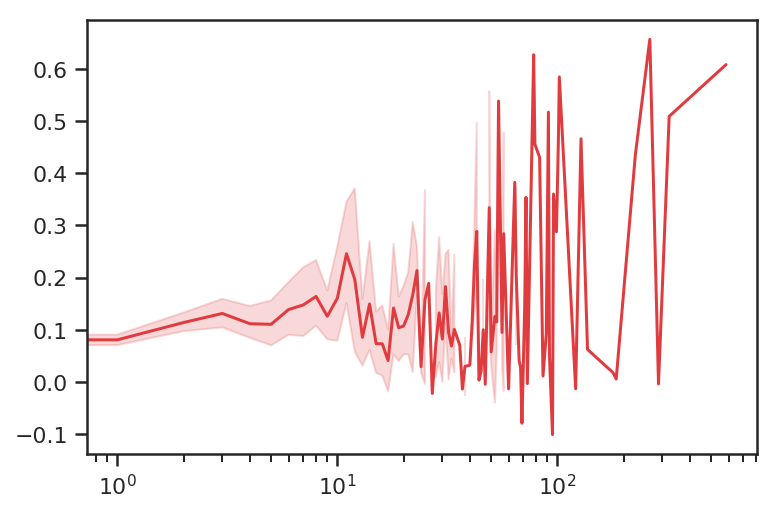

In [128]:
sns.lineplot(db_drugs_exp.drug_counts, db_drugs_exp.ci_weights/np.sqrt(all_drugs_exp.degrees))
plt.xscale('log')

In [131]:
# all proteins
db_drugs_exp.compute_weight_stats()

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [132]:
# targetted proteins
all_drugs_exp.compute_weight_stats(np.where(db_drugs_exp.drug_counts != 0))

{'mean': 0.10898323313357415,
 'median': 0.037927002779722954,
 'std': 0.1858858799271381}

In [133]:
# not targetted proteins
all_drugs_exp.compute_weight_stats(np.where(db_drugs_exp.drug_counts == 0))

{'mean': 0.039129253341947626,
 'median': 0.018487800259319037,
 'std': 0.11559934564168145}

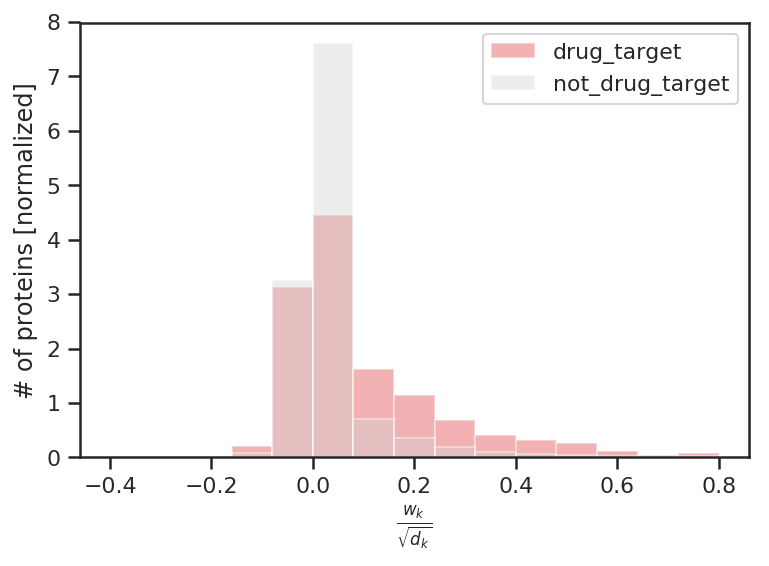

In [147]:
all_drugs_exp.plot_drug_weight_dist({"drug_target": np.where(db_drugs_exp.drug_counts > 0),
                                     "not_drug_target": np.where(db_drugs_exp.drug_counts == 0)})

In [159]:
top_proteins = np.argsort(db_drugs_exp.ci_weights_norm)[-500:]

In [160]:
db_drugs_exp.compute_frac_targets(top_proteins)

0.336

In [140]:
bottom_proteins = np.argsort(db_drugs_exp.ci_weights_norm)[:-500]

In [141]:
db_drugs_exp.compute_frac_targets(bottom_proteins)

0.09706985800446408

In [162]:
db_drugs_exp.frac_targets_ks_test(top_proteins, bottom_proteins).pvalue

6.435228672481076e-25

In [168]:
db_drugs_exp.add_params({"top_k": 500})

In [170]:
db_drugs_exp.run()

True

### Essential Genes


In [68]:
# load essential genes
essential_proteins = []
with open("data/protein/essential.txt") as f:
    for line in f:
        line = line.strip(" \n")
        if line[0] == "#":
            continue
        
        entrez_id = int(line)
        essential_proteins.append(entrez_id)

In [79]:
essential_nodes = network.get_nodes(essential_proteins)
essential_nodes

array([ 7977,  2643,  2867, ...,  6130, 18893,  3527])

In [162]:
all_stats = {
    "mean": np.mean(ci_weights/np.sqrt(degrees)),
    "median": np.median(ci_weights/np.sqrt(degrees)),
    "std": np.std(ci_weights/np.sqrt(degrees))
}
all_stats

{'mean': 0.046297087609196215,
 'median': 0.01905014371925729,
 'std': 0.12643935388432098}

In [165]:
essential_bool = np.zeros(len(network)).astype(bool)
essential_bool[essential_nodes] = True
essential_stats = {
    "sum": np.sum((ci_weights/np.sqrt(degrees))[essential_bool]),
    "mean": np.mean((ci_weights/np.sqrt(degrees))[essential_bool]),
    "median": np.median((ci_weights/np.sqrt(degrees))[essential_bool]),
    "std": np.std((ci_weights/np.sqrt(degrees))[essential_bool])
}
essential_stats

{'sum': 338.7407239486723,
 'mean': 0.05305258010159316,
 'median': 0.01354711676914155,
 'std': 0.13290532187181922}

In [156]:
np.sum(essential_bool)

6385

In [157]:
np.sum(non_essential_nodes)

15172

In [161]:
np.dot(essential_bool, non_essential_bools)

0

In [167]:
np.sum((ci_weights/np.sqrt(degrees)))

998.0263175914428

In [168]:
non_essential_bools = (1 - essential_bool).astype(bool)
non_essential_stats = {
    "sum": np.sum((ci_weights/np.sqrt(degrees))[non_essential_bools]),
    "mean": np.mean((ci_weights/np.sqrt(degrees))[non_essential_bools]),
    "median": np.median((ci_weights/np.sqrt(degrees))[non_essential_bools]),
    "std": np.std((ci_weights/np.sqrt(degrees))[non_essential_bools])
}
non_essential_stats

{'sum': 659.2855936427704,
 'mean': 0.04345409923825273,
 'median': 0.021358098034775397,
 'std': 0.12350671027062278}

In [199]:
top_proteins = np.argsort(ci_weights)[-500:]

In [200]:
np.mean(essential_bool[top_proteins])

0.532

In [201]:
bottom_proteins = np.argsort(ci_weights)[:500]

In [202]:
np.mean(essential_bool[bottom_proteins])

0.51